In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.preprocessing import MinMaxScaler

In [54]:
df = pd.read_csv('AB_NYC_2019.csv')
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539.0,Clean & quiet apt home by the park,2787.0,John,Brooklyn,Kensington,40.647490,-73.972370,Private room,149,1.0,9.0,2018-10-19,0.21,6.0,365.0
1,2595.0,Skylit Midtown Castle,2845.0,Jennifer,Manhattan,Midtown,40.753620,-73.983770,Entire home/apt,225,1.0,45.0,2019-05-21,0.38,2.0,355.0
2,3647.0,THE VILLAGE OF HARLEM....NEW YORK !,4632.0,Elisabeth,Manhattan,Harlem,40.809020,-73.941900,Private room,150,3.0,0.0,NaN,NaN,1.0,365.0
3,3831.0,Cozy Entire Floor of Brownstone,4869.0,LisaRoxanne,Brooklyn,Clinton Hill,40.685140,-73.959760,Entire home/apt,89,1.0,270.0,2019-07-05,4.64,1.0,194.0
4,5022.0,Entire Apt: Spacious Studio/Loft by central park,7192.0,Laura,Manhattan,East Harlem,40.798510,-73.943990,Entire home/apt,80,10.0,9.0,2018-11-19,0.10,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48891,36485057.0,Affordable room in Bushwick/East Williamsburg,6570630.0,Marisol,Brooklyn,Bushwick,40.701840,-73.933170,Private room,40,4.0,0.0,NaN,NaN,2.0,36.0
48892,36485431.0,Sunny Studio at Historical Neighborhood,23492952.0,Ilgar & Aysel,Manhattan,Harlem,40.814750,-73.948670,Entire home/apt,115,10.0,0.0,NaN,NaN,1.0,27.0
48893,36485609.0,43rd St. Time Square-cozy single bed,30985759.0,Taz,Manhattan,Hell's Kitchen,40.757510,-73.991120,Shared room,55,1.0,0.0,NaN,NaN,6.0,2.0
48894,36487245.0,Trendy duplex in the very heart of Hell's Kitchen,68119814.0,Christophe,Manhattan,Hell's Kitchen,40.764040,-73.989330,Private room,90,7.0,0.0,NaN,NaN,1.0,23.0


In [52]:
df.drop(df.index[-1], inplace=True)
df.to_csv('AB_NYC_2019.csv', index=False)

Spatial Visualization: neighbourhood_group, neighbourhood, latitude, longitude, and price.

In [3]:
df_spatial = df[['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'price']].copy()
df_spatial

,neighbourhood_group,neighbourhood,latitude,longitude,price
0,Brooklyn,Kensington,40.647490,-73.972370,149
1,Manhattan,Midtown,40.753620,-73.983770,225
2,Manhattan,Harlem,40.809020,-73.941900,150
3,Brooklyn,Clinton Hill,40.685140,-73.959760,89
4,Manhattan,East Harlem,40.798510,-73.943990,80
...,...,...,...,...,...
48892,Manhattan,Harlem,40.814750,-73.948670,115
48893,Manhattan,Hell's Kitchen,40.757510,-73.991120,55
48894,Manhattan,Hell's Kitchen,40.764040,-73.989330,90
48895,Bronx,Pelham Gardens,40.862018,-73.840767,112


Checking for normalization requirements

In [4]:
df_spatial.isnull().sum(),df_spatial.dtypes, df_spatial.describe()


(neighbourhood_group    0
 neighbourhood          0
 latitude               0
 longitude              0
 price                  0
 dtype: int64,
 neighbourhood_group     object
 neighbourhood           object
 latitude               float64
 longitude              float64
 price                    int64
 dtype: object,
            latitude     longitude         price
 count  48897.000000  48897.000000  48897.000000
 mean      40.728948    -73.952172    152.716731
 std        0.054539      0.046169    240.150322
 min       40.499790    -74.244420      0.000000
 25%       40.690100    -73.983070     69.000000
 50%       40.723070    -73.955680    106.000000
 75%       40.763120    -73.936270    175.000000
 max       40.913060    -73.712990  10000.000000)

Removing outliers

In [5]:
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [6]:
upper_array = np.where(df_spatial['price'] >= upper_bound)[0]
lower_array = np.where(df_spatial['price'] <= lower_bound)[0]

In [7]:
df_spatial.drop(index=upper_array, inplace=True)
df_spatial.drop(index=lower_array, inplace=True)

Checking for confirmation of outliers removal

In [8]:
print(df.shape[0])
print(df_spatial.shape[0])

48897
45920


Mapping out the spatial analysis using folium

In [9]:
df_spatial_grouped = df_spatial.groupby(['neighbourhood_group', 'neighbourhood']).agg(
    mean_price=('price', 'mean'),
    latitude=('latitude', 'mean'),
    longitude=('longitude', 'mean')
).reset_index()
df_spatial_grouped



,neighbourhood_group,neighbourhood,mean_price,latitude,longitude
0,Bronx,Allerton,78.756098,40.865164,-73.859018
1,Bronx,Baychester,75.428571,40.873616,-73.842967
2,Bronx,Belmont,77.125000,40.855062,-73.887109
3,Bronx,Bronxdale,57.105263,40.854731,-73.866287
4,Bronx,Castle Hill,63.000000,40.816889,-73.847000
...,...,...,...,...,...
214,Staten Island,Tompkinsville,76.190476,40.633135,-74.086465
215,Staten Island,Tottenville,144.857143,40.507350,-74.239390
216,Staten Island,West Brighton,80.555556,40.631932,-74.115959
217,Staten Island,Westerleigh,71.500000,40.613895,-74.133665


In [10]:
scaler = MinMaxScaler()

reshaped = df_spatial_grouped['mean_price'].values.reshape(-1, 1)

normalization = scaler.fit_transform(reshaped).flatten()

In [11]:
def get_color(normalization):
    color = plt.get_cmap('RdYlGn_r')(normalization)
    return matplotlib.colors.to_hex(color[:3])

In [12]:
color_codes = [get_color(norm_price) for norm_price in normalization]
df_spatial_grouped['color_code'] = color_codes
df_spatial_grouped

,neighbourhood_group,neighbourhood,mean_price,latitude,longitude,color_code
0,Bronx,Allerton,78.756098,40.865164,-73.859018,#42ac5a
1,Bronx,Baychester,75.428571,40.873616,-73.842967,#36a657
2,Bronx,Belmont,77.125000,40.855062,-73.887109,#3ca959
3,Bronx,Bronxdale,57.105263,40.854731,-73.866287,#0c7f43
4,Bronx,Castle Hill,63.000000,40.816889,-73.847000,#138c4a
...,...,...,...,...,...,...
214,Staten Island,Tompkinsville,76.190476,40.633135,-74.086465,#39a758
215,Staten Island,Tottenville,144.857143,40.507350,-74.239390,#f8fcb6
216,Staten Island,West Brighton,80.555556,40.631932,-74.115959,#4bb05c
217,Staten Island,Westerleigh,71.500000,40.613895,-74.133665,#279f53


In [13]:
nyc_map = folium.Map(location= [40.7128, -74.0060],zoom_start= 10.5, control_scale=True)

In [14]:
for _, row in df_spatial_grouped.iterrows():
    popup_message = folium.Popup(f"{row['neighbourhood_group']}, {row['neighbourhood']}: Average Price ${row['mean_price']:.2f}")
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=row['color_code'],
        fill=True,
        fill_color=row['color_code'],
        popup=popup_message
    ).add_to(nyc_map)


In [15]:
nyc_map

In [16]:
nyc_map.save('nyc_map.html')

/Users/tomtran/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

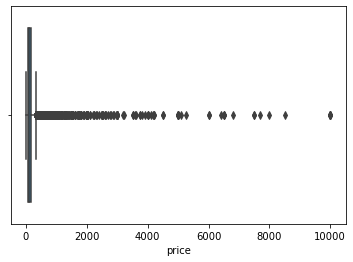

In [17]:
sns.boxplot(df['price'])

/Users/tomtran/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

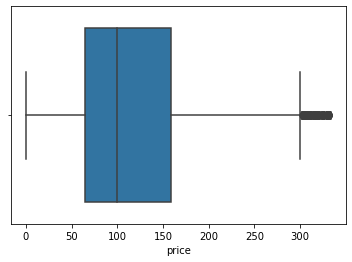

In [18]:
sns.boxplot(df_spatial['price'])

Non Spatial: neighbourhood_group and price

In [19]:
df_non_spatial = df[['neighbourhood_group', 'price']].copy()
df_non_spatial

,neighbourhood_group,price
0,Brooklyn,149
1,Manhattan,225
2,Manhattan,150
3,Brooklyn,89
4,Manhattan,80
...,...,...
48892,Manhattan,115
48893,Manhattan,55
48894,Manhattan,90
48895,Bronx,112


Checking for normalization requirements

In [20]:
df_non_spatial.isnull().sum(),df_non_spatial.dtypes, df_non_spatial.describe()

(neighbourhood_group    0
 price                  0
 dtype: int64,
 neighbourhood_group    object
 price                   int64
 dtype: object,
               price
 count  48897.000000
 mean     152.716731
 std      240.150322
 min        0.000000
 25%       69.000000
 50%      106.000000
 75%      175.000000
 max    10000.000000)

Removing Outliers

In [21]:
upper_array = np.where(df_non_spatial['price'] >= upper_bound)[0]
lower_array = np.where(df_non_spatial['price'] <= lower_bound)[0]

In [22]:
df_non_spatial.drop(index=upper_array, inplace=True)
df_non_spatial.drop(index=lower_array, inplace=True)

Checking for confirmation of outliers removal

In [23]:
print(df.shape[0])
print(df_non_spatial.shape[0])

48897
45920


In [24]:
df_non_spatial_grouped = df_spatial.groupby('neighbourhood_group')['price'].mean().reset_index()

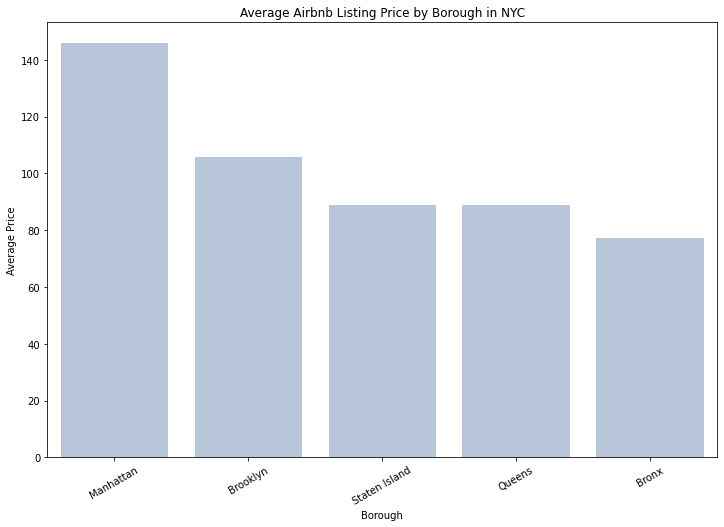

In [25]:
plt.figure(figsize=(12, 8))
sns.barplot(x='neighbourhood_group', y='price', data=df_non_spatial_grouped.sort_values('price', ascending= False), color='lightsteelblue')
plt.title('Average Airbnb Listing Price by Borough in NYC')
plt.xlabel('Borough')
plt.ylabel('Average Price')
plt.xticks(rotation=30)
plt.show()